This is image classification with few good practices.

Uses the following frameworks:

- PyTorch Lightning
- TorchMetrics

TODO:

- [x] data loader workers?
- [x] Precision, Recall, F1 score
- [ ] Confusion matrix
- [x] LR scheduler
- [ ] Checkpoint save?

In [1]:
! pip install --upgrade pytorch_lightning albumentations wandb

In [2]:
from typing import Optional, List, Union
import cv2
import numpy as np
import pytorch_lightning as pl
import torch
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch import nn
from torch.utils.data import random_split, DataLoader
from torchvision.datasets import CIFAR10, CIFAR100
from pytorch_lightning.loggers import WandbLogger
from torch.nn import functional as F
from matplotlib import pyplot as plt
from torchmetrics import AverageMeter, Accuracy, Precision, Recall, MetricCollection

In [3]:
class Cifar100Dataset(pl.LightningDataModule):
    def __init__(
        self,
        batch_size: int,
        data_path: str,
        val_split: float,
        dataloader_num_workers: int = 0,
        manual_seed=None,
        data_augment=False,
        **_,
    ):
        super().__init__()

        self.h = 32
        self.w = 32
        self.dims = (3, self.h, self.w)

        self.data_path = data_path
        self.batch_size = batch_size
        self.val_split = val_split
        self.num_workers = dataloader_num_workers
        self.manual_seed = manual_seed
        self.augment = data_augment

        self.transform_train_val, self.transform_test = self._get_transforms()

        self.dataset_train, self.dataset_val, self.dataset_test = None, None, None

    def prepare_data(self):
        # download
        CIFAR100(self.data_path, train=True, download=True)
        CIFAR100(self.data_path, train=False, download=True)

    def setup(self, stage: Optional[str] = None):
        """
        :param stage: One of {fit, validate, test}. None = all 3
        :return:
        """

        # Assign train/val datasets for use in dataloaders
        if stage == "fit" or stage is None:
            dataset_full = CIFAR100(
                self.data_path, train=True, transform=self.transform_train_val
            )

            full_size = len(dataset_full)
            val_size = int(full_size * self.val_split)
            generator = None
            if self.manual_seed:
                generator = torch.Generator().manual_seed(self.manual_seed)

            self.dataset_train, self.dataset_val = random_split(
                dataset_full,
                [full_size - val_size, val_size],
                generator=generator,
            )

        # Assign test dataset for use in dataloader(s)
        if stage == "test" or stage is None:
            self.dataset_test = CIFAR100(
                self.data_path, train=False, transform=self.transform_test
            )

    def train_dataloader(self):
        return DataLoader(
            self.dataset_train,
            batch_size=self.batch_size,
            shuffle=True,
            num_workers=self.num_workers,
        )

    def val_dataloader(self):
        return DataLoader(
            self.dataset_val,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def test_dataloader(self):
        return DataLoader(
            self.dataset_test,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=self.num_workers,
        )

    def _get_transforms(self):
        resize_transform: list = [
            A.PadIfNeeded(
                min_height=self.h, min_width=self.w, border_mode=cv2.BORDER_CONSTANT
            ),
            A.RandomCrop(self.h, self.w),
        ]

        augmentations: list = []
        if self.augment:
            augmentations = [
                A.HorizontalFlip(p=0.5),
                A.RandomBrightnessContrast(p=0.2),
            ]

        def _normalizer(image, **_):
            return image / 255.0

        compatible: list = [
            ToTensorV2(always_apply=True),
            A.Lambda(image=_normalizer),
        ]

        transforms_train_val_ = A.Compose(resize_transform + augmentations + compatible)
        transforms_test_ = A.Compose(resize_transform + compatible)

        def transforms_train_val(image):
            return transforms_train_val_(image=np.array(image))["image"]

        def transforms_test(image):
            return transforms_test_(image=np.array(image))["image"]

        return transforms_train_val, transforms_test


Files already downloaded and verified
Files already downloaded and verified
torch.Size([2, 3, 32, 32]) torch.Size([2])


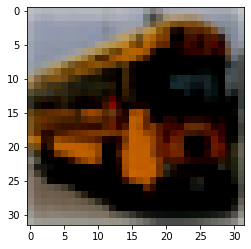

In [4]:
def debug1():
    config = {
        "data_path": "../data",
        "val_split": 0.3,
        "batch_size": 2,
        "output_path": "./output",
        "model_save_frequency": 5,
        "dataloader_num_workers": 0,
        "data_augment": True,
    }
    dataset = Cifar100Dataset(**config)

    dataset.prepare_data()
    dataset.setup()
    loader = dataset.train_dataloader()
    for image, classes in loader:
        print(image.shape, classes.shape)
        plt.imshow(image[0].moveaxis(0, -1))
        plt.show()
        break

    # hp = {
    #     "epochs": 10,
    #     "lr_initial": 0.0001,
    #     "lr_decay_every": 30,
    #     "lr_decay_by": 0.3,
    # }
    # model = MnistModel(**hp, **config)
    # y = model(image)
    # print(y.shape)


debug1()


In [5]:
class CNNBlock(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(CNNBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.batchnorm = nn.BatchNorm2d(out_channels)
        self.leakyrelu = nn.LeakyReLU(0.1)

    def forward(self, x):
        return self.leakyrelu(self.batchnorm(self.conv(x)))


class SimpleCNN(nn.Module):
    def __init__(
        self,
        architecture: List[Union[tuple, str, list]],
        in_channels: int,
    ):
        super(SimpleCNN, self).__init__()
        layers = []
        for module in architecture:
            if type(module) is tuple:
                layers.append(self._get_cnn_block(module, in_channels))
                in_channels = module[1]
            elif module == "M":
                layers.append(
                    nn.MaxPool2d(
                        kernel_size=(2, 2),
                        stride=(2, 2),
                    )
                )
            elif type(module) is list:
                for i in range(module[-1]):
                    for j in range(len(module) - 1):
                        layers.append(self._get_cnn_block(module[j], in_channels))
                        in_channels = module[j][1]
        self.model = nn.Sequential(*layers)

    @staticmethod
    def _get_cnn_block(module: tuple, in_channels):
        kernel_size, filters, stride, padding = module
        return CNNBlock(
            in_channels,
            filters,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )

    def forward(self, x):
        return self.model(x)

In [6]:
class Cifar100Model(pl.LightningModule):
    def __init__(self, **hp):
        super().__init__()
        self.num_classes = 100
        architecture = [
            # (kernel_size, filters, stride, padding)
            (3, 10, 1, 1),
            #(3, 128, 1, 1),
            "M",
            (3, 20, 1, 1),
            #(3, 256, 1, 1),
            "M",
            (3, 20, 1, 1),
            #(3, 512, 1, 1),
            "M",
            (3, self.num_classes, 1, 0),
        ]

        self.model = nn.Sequential(
            SimpleCNN(architecture, in_channels=3),
            nn.AdaptiveAvgPool2d((1, 1)),
            nn.Flatten(),
        )

        self.hp = hp
        self.save_hyperparameters(hp)

        self.criterion = nn.CrossEntropyLoss()

        # Metrics
        self.loss_train = AverageMeter()
        self.loss_val = AverageMeter()
        self.metrics_train = MetricCollection({
            'accuracy': Accuracy(),
            'precision': Precision(average='macro', num_classes=self.num_classes),
            'recall': Recall(average='macro', num_classes=self.num_classes)
        }, prefix='train/')
        self.metrics_val = self.metrics_train.clone(prefix='val/')

    def forward(self, x):
        return self.model(x)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hp["lr_initial"])
        lr_scheduler = torch.optim.lr_scheduler.StepLR(
            optimizer,
            step_size=self.hp['lr_decay_every'],
            gamma=self.hp['lr_decay_by'],
        )
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': lr_scheduler,
                'interval': 'epoch',
                "frequency": 1,
                "name": "learning_rate"
            }
        }

    def training_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images)
        loss = self.criterion(preds, targets)
        return {
            "loss": loss,
            "preds": preds.detach(),
            "inputs": images,
            "targets": targets,
        }

    def training_step_end(self, outs: dict):
        self.loss_train(outs["loss"])
        self.metrics_train(outs["preds"], outs["targets"])
        self.log("train/accuracy_step", self.metrics_train['accuracy'], prog_bar=True)

    def training_epoch_end(self, outs: dict):
        self.log("train/loss", self.loss_train.compute())
        self.log_dict(self.metrics_train.compute())
        self.log('learning_rate', self.lr_schedulers().get_last_lr()[0])

    def validation_step(self, batch, batch_idx):
        images, targets = batch
        preds = self(images)
        loss = self.criterion(preds, targets)
        return {
            "loss": loss,
            "preds": preds.detach(),
            "inputs": images,
            "targets": targets,
        }

    def validation_step_end(self, outs: dict):
        self.metrics_val(outs["preds"], outs["targets"])
        self.loss_val(outs["loss"])

    def on_validation_epoch_end(self) -> None:
        self.log_dict(self.metrics_val.compute())
        self.log("val/loss", self.loss_val.compute())

In [7]:
def train():
    hp = {
        "epochs": 5,
        "lr_initial": 0.0001,
        "lr_decay_every": 2,
        "lr_decay_by": 0.9,
    }

    config = {
        "data_path": "../data",
        "val_split": 0.05,
        "batch_size": 64,
        "manual_seed": 2,
        "output_path": "./output",
        "model_save_frequency": 5,
        "dataloader_num_workers": 8,
        "data_augment": True,
    }

    dataset = Cifar100Dataset(**config)
    model = Cifar100Model(**hp, **config)
    wandb_logger = WandbLogger(project="classification_test", log_model=True)
    trainer = pl.Trainer(
        gpus=1,
        max_epochs=hp["epochs"],
        default_root_dir=config["output_path"],
        logger=wandb_logger,
    )
    # wandb_logger.watch(model)

    trainer.fit(model, datamodule=dataset)


train()

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Files already downloaded and verified
Files already downloaded and verified


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
wandb: Currently logged in as: akhilez (use `wandb login --relogin` to force relogin)



  | Name          | Type             | Params
---------------------------------------------------
0 | model         | Sequential       | 24.0 K
1 | criterion     | CrossEntropyLoss | 0     
2 | loss_train    | AverageMeter     | 0     
3 | loss_val      | AverageMeter     | 0     
4 | metrics_train | MetricCollection | 0     
5 | metrics_val   | MetricCollection | 0     
---------------------------------------------------
24.0 K    Trainable params
0         Non-trainable params
24.0 K    Total params
0.096     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Training: -1it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]